In [15]:
import mercury as mr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
from textwrap import wrap
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

## Tableau des compétences
<hr>

In [45]:
# TELECHARGEMENT DU FICHIER MASTER
# Ajouter un widget de téléchargement de fichier
my_file = mr.File(label="Téléchargement de fichier")

if my_file.filepath is None:
    mr.Stop()

# Charger les données du fichier CSV
df = pd.read_excel(my_file.filepath, index_col=0)
#df = pd.read_excel('/home/nicolasbremond/Nextcloud/PHOENIX CONSEIL/0 - GESTION/0 - MODELES POUR OFFRE/Matrices des competences - BASE.xlsx', index_col=0)
df_max = pd.DataFrame([df.max()], columns=df.columns)
df_max.index = ['Synthese']


list_ressource = list(df.index.values)
list_ressource.append('Tous')
list_ressource.append('Synthese')


choice_ticker = 'Tous'
ticker = mr.Select(value='Tous', choices=list_ressource, label="Selectionnez une ressource :")
choice_ticker = ticker.value

if choice_ticker == 'Tous':
    choice_ticker2 = 'Traits simples'
    ticker2 = mr.Select(value='Traits détaillés', choices=['Traits détaillés','Traits simples'], label="Selectionnez une répresentation de trait :")
    choice_ticker2 = ticker2.value

# Round the values
df = df.round(1)

# Define the colormap
colors = ['#F4AF81', '#FEF2CB', '#A9D08D']  # Orange, Yellow, Green
n_bins = 100  # Discretizes the interpolation into bins
cmap_name = 'orange_yellow_green'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Style the DataFrame
styled_df = df.style.set_properties(
    **{'text-align': 'center', 'white-space': 'normal'}  # Enable text wrapping
).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center'), ('white-space', 'normal')]},
    {'selector': 'td:first-child', 'props': [('text-align', 'left')]},
    {'selector': 'td, th', 'props': [('border', '1px solid lightgray')]},
    {'selector': 'table', 'props': [('border', 'none'), ('table-layout', 'fixed'), ('width', '100%')]},  # Fixed table layout
    {'selector': 'th:nth-child(1)', 'props': [('width', '20%')]},  # Adjust the width of the first column
    {'selector': 'th', 'props': [('width', '10%')]},  # Adjust the width of the other columns
]).format(precision=1).background_gradient(cmap=cm, axis=None)

display(styled_df)


mercury.File

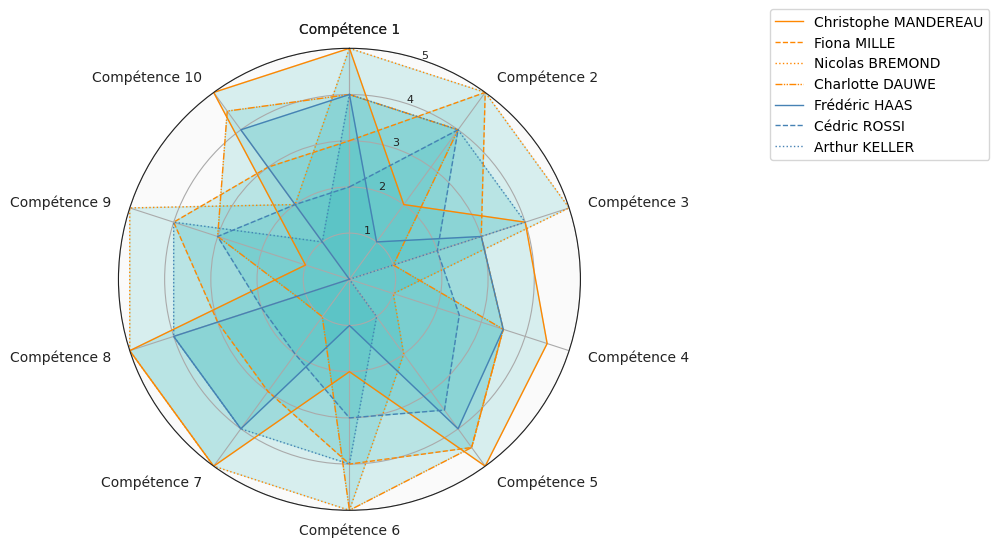

In [44]:
# The attributes we want to use in our radar plot.
labels = list(df.columns[0:])

labels = ["\n".join(wrap(r[:38] + ('...' if len(r) > 38 else ''), 22, break_long_words=False)) for r in labels]

num_vars = len(labels)

# Split the circle into even parts and save the angles so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop" and append the start value to the end.
angles += angles[:1]
labels += labels[:1]

# Create the figure and polar subplot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# List of colors for the border
border_colors = ['#FF8700', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2']
# List of line styles
line_styles = ['-', '--', ':', (0, (5, 1, 1, 1, 1, 1))]  # Adding double line style
# List of line widths
line_widths = [1, 1.5]
# Constant fill color
fill_color = '#14aeb0'

# Helper function to plot each car on the radar chart.
def add_to_radar(car_model, line_style, color, line_width):
    values = df.loc[car_model].tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=line_width, linestyle=line_style, label=car_model)
    ax.fill(angles, values, color=fill_color, alpha=0.15)

if choice_ticker == "Tous":
    total_styles = len(line_styles) * len(border_colors) * len(line_widths)
    for i, car_model in enumerate(df.index):
        if choice_ticker2 == 'Traits détaillés':
            line_style = line_styles[i % len(line_styles)]
            color = border_colors[(i // len(line_styles)) % len(border_colors)]
            line_width = line_widths[(i // (len(line_styles) * len(border_colors))) % len(line_widths)]
            add_to_radar(car_model, line_style, color, line_width)
        else:
            line_style = line_styles[0]
            color = border_colors[0]
            line_width = line_widths[0]
            add_to_radar(car_model, line_style, color, line_width)            
elif choice_ticker == "Synthese":
    values = df_max.loc[choice_ticker].tolist()
    values += values[:1]
    ax.plot(angles, values, color='#FF8700', linewidth=1, linestyle='-', label=choice_ticker)
    ax.fill(angles, values, color=fill_color, alpha=0.15)
else:
    line_style = line_styles[0]
    color = border_colors[0]
    line_width = line_widths[0]
    add_to_radar(choice_ticker, line_style, color, line_width)

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles), labels)

# Go through labels and adjust alignment based on where it is in the circle.
for label, angle in zip(ax.get_xticklabels(), angles):
    if angle in (0, np.pi):
        label.set_horizontalalignment('center')
    elif 0 < angle < np.pi:
        label.set_horizontalalignment('left')
    else:
        label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(0, 5)

# Set position of y-labels (0-100) to be in the middle of the first two axes.
ax.set_rlabel_position(180 / num_vars)

# Add some custom styling.
# Change the color of the tick labels.
ax.tick_params(colors='#222222')
# Make the y-axis (0-100) labels smaller.
ax.tick_params(axis='y', labelsize=8)
# Change the color of the circular gridlines.
ax.grid(color='#AAAAAA')
# Change the color of the outermost gridline (the spine).
ax.spines['polar'].set_color('#222222')
# Change the background color inside the circle itself.
ax.set_facecolor('#FAFAFA')

# Add a legend as well.
ax.legend(loc='upper right', bbox_to_anchor=(1.9, 1.1))

plt.show()